# Simulation

In [304]:
import random 
from collections import Counter

def roll_attr():
    rolls = [random.randint(1,6) for _ in range(4)]
    return sum(sorted(rolls)[1:])

def simulate_char():
    stat = [0,0,0,0,0,0]
    bad_char = True
    while bad_char:
        stat = [roll_attr() for _ in stat]
        bad_char = (max(stat) <= 13) or (sum(stat) <= 60)
    return stat

n = 100000
c = Counter([sum(simulate_char()) for _ in range(n)])
probs_simu = {k:v/n for k,v in dict(c).items()}
probs_simu

{61: 0.00787,
 62: 0.01045,
 63: 0.01407,
 64: 0.01757,
 65: 0.02328,
 66: 0.02883,
 67: 0.03355,
 68: 0.03943,
 69: 0.04599,
 70: 0.0491,
 71: 0.0556,
 72: 0.05747,
 73: 0.06237,
 74: 0.06141,
 75: 0.06062,
 76: 0.05964,
 77: 0.05597,
 78: 0.05209,
 79: 0.04778,
 80: 0.04201,
 81: 0.03684,
 82: 0.03117,
 83: 0.02602,
 84: 0.02178,
 85: 0.01671,
 86: 0.0126,
 87: 0.00952,
 88: 0.00714,
 89: 0.00452,
 90: 0.00343,
 91: 0.00205,
 92: 0.00137,
 93: 0.00073,
 94: 0.00051,
 95: 0.00033,
 96: 8e-05,
 97: 6e-05,
 98: 4e-05}

# Iteration

In [259]:
import itertools as it 
d = (1,2,3,4,5,6)
roll_counter = Counter((tuple(sorted(_)[1:]) for _ in it.product(d,d,d,d)))

In [260]:
roll_counter = Counter((sum(sorted(_)[1:]) for _ in it.product(d,d,d,d)))

In [261]:
roll_counter

Counter({3: 1,
         4: 4,
         5: 10,
         6: 21,
         7: 38,
         8: 62,
         9: 91,
         10: 122,
         11: 148,
         12: 167,
         13: 172,
         14: 160,
         15: 131,
         16: 94,
         17: 54,
         18: 21})

In [262]:
import operator as op
from functools import reduce

k = roll_counter.items()

def roll_gt(tups, n):
    min([_[0] for _ in tups]) > 13
    return sum([_[0] for _ in tups]) > 60

def map_vals(tups):
    rolled_value = sum([_[0] for _ in tups])
    how_often = reduce(lambda x,y:x*y, [_[1] for _ in tups])
    return Counter({rolled_value: how_often})

sum(1 for comb in it.product(k,k,k,k,k,k) if roll_gt(comb, 60))

9822736

It takes an increasing amount of time to add counter objects.

In [263]:
mapped = (map_vals(_) for _ in it.product(k,k,k,k,k,k) if roll_gt(_, 60))

In [264]:
%%time
folded = reduce(op.add, mapped)
folded

CPU times: user 5min 41s, sys: 865 ms, total: 5min 42s
Wall time: 5min 43s


In [265]:
import matplotlib.pylab as plt
%matplotlib inline

In [266]:
sum(roll_counter.values())

1296

In [267]:
probs_iter = {k:v/sum(folded.values()) for k,v in folded.items()}
(1296)**6, sum(folded.values())

(4738381338321616896, 4574806877154126670)

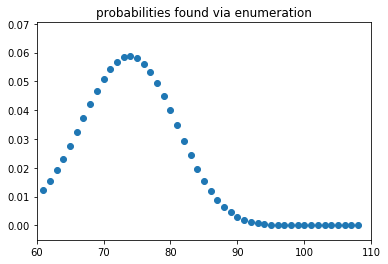

In [268]:
plt.scatter(list(probs_iter.keys()), list(probs_iter.values()))
plt.xlim(60, 110)
plt.ylim(-0.005, 0.0705)
plt.title("probabilities found via enumeration")

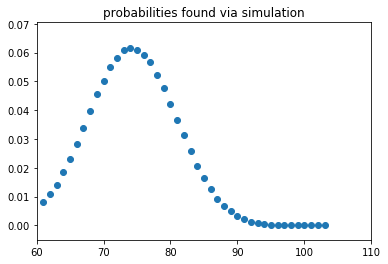

In [269]:
plt.scatter(list(probs_simu.keys()), list(probs_simu.values()))
plt.xlim(60, 110)
plt.ylim(-0.005, 0.0705)
plt.title("probabilities found via simulation")

We will use `probs_iter` and `probs_sim` to see how much the approximation causes a difference. 

### Decision Theory

We need to calculate the probability that you'll get a higher score if you roll again. 

The goal is not to get a higher score in this one next roll, but a higher score in any roll that comes after. Intuitively this probability is defined via; 

$$ 
\begin{split}
\mathbb{P}(\text{higher than } s_0 \text{at roll } r) = & \mathbb{P}(s_1 > s_0 + r + 1) + \\
  & \mathbb{P}(s_2 > s_0 + r + 2)\mathbb{P}(s_1 \leq s_0 + r + 1) +\\
  & \mathbb{P}(s_3 > s_0 + r + 3)\mathbb{P}(s_2 \leq s_1 + r + 1)\mathbb{P}(s_1 \leq s_0 + r + 1) +\\
  & \mathbb{P}(s_4 > s_0 + r + 4)\mathbb{P}(s_3 \leq s_2 + r + 1)\mathbb{P}(s_2 \leq s_1 + r + 1)\mathbb{P}(s_1 \leq s_0 + r + 1) +\\
  ...
\end{split}
$$ 


In [327]:
import numba as nb

def p_higher_next(val, probs):
    return sum([v for k,v in probs.items() if k >= val])


def prob_higher(score, n_rolls, probs):
    if score <= 60:
        raise ValueError("score must be > 60")
    p = 0
    for roll in range(n_rolls + 1, max(probs.keys())+1):
        higher_p = p_higher_next(score + roll, probs) 
        fails_p = reduce(lambda a,b: a*b, [1] + [1-p_higher_next(score + _, probs) for _ in range(roll - n_rolls - 1)])
        p += higher_p*fails_p
    return p
    

@nb.jit
def decisions_matrix(probs, choice=lambda x: x):
    matrix = []
    for score in reversed(list(probs.keys())):
        row = []
        for roll in range(1,25):
            output = prob_higher(score, roll, probs)
            output = choice(output)
            row.append(output)
        matrix.append(row)
    return matrix

def plot_decisions(probs, choice=lambda x: x, title=""):
    mat = decisions_matrix(probs, choice)
    plt.imshow(mat, 
               interpolation='none', 
               extent=[1, len(mat_p[0]), min(probs.keys()), max(probs.keys())])
    plt.title(title)
    _ = plt.colorbar();

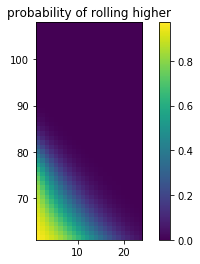

In [328]:
plot_decisions(probs_iter, 
               title="probability of rolling higher")

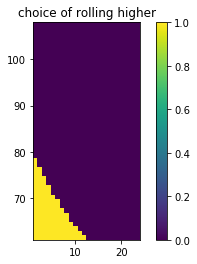

In [329]:
plot_decisions(probs_iter, choice=round, 
               title="choice of rolling higher")

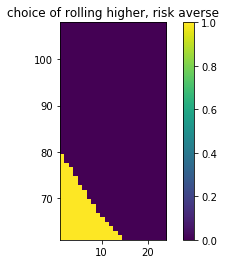

In [330]:
plot_decisions(probs_iter, choice=lambda x: round(x+0.1), 
               title="choice of rolling higher, risk averse")

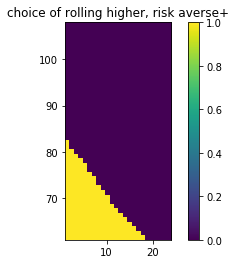

In [334]:
plot_decisions(probs_iter, choice=lambda x: round(x+0.3), 
               title="choice of rolling higher, risk averse+")

## Making the model too simple

An alternative way of thinking about it is to say that we merely want to optimise this: 

$$ \text{argmax } v(a, s, t)= 
\begin{cases}
    s - t,& \text{if } a\\\\
    \mathbb{E}(s) - t - 1 & \text{if not } a
\end{cases}
$$

In [325]:
expected_value = sum([k*v for k,v in probs_iter.items()])
expected_value

74.03527564970476

You should feel that this viewpoint is a bit naive as suddenly the system 
becomes very linear. To show that this tactic is different, albeit somewhat similar, let's plot the two decision regions.

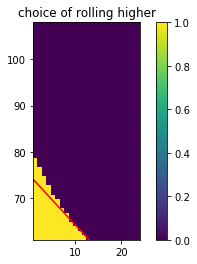

In [335]:
plot_decisions(probs_iter, choice=round, 
               title="choice of rolling higher")
plt.plot([1, 13], [expected_value, expected_value-13], color="red")

# Conclusions

This "icewind dale problem" is very similar to the "secretary problem" or the "dating problem". All these problem focus on finding the right moment to stop and reap the benefits. The problems differ on a few things which can make the problem harder: 

- in our problem we are always able to reroll, you could imagine a situation where there is a chance of being able to reroll 
- we knew the stochastic process that generates scores beforehand, you could imagine that if we do not know how the attribute scores are generated that the problem becomes a whole lot harder too 
- 

Then looking back at how I solved this problem I'd like to mention a few observations too. 

- This is a rare case where you are able to enumerate the probabilities instead of simulating them. I find that you should celebrate these moments by doing the actual work to get the actual probabilities out.  It requires more mental capacity though, initially working with simulations may also just be fine if you're just exploring. 
- I took the proper math path and I showed that the $\text{argmax } \mathbb{E}(s)$ expected value heuristic is flawed, albeit not too far off. If you only want to spend 5 minutes on the problem I guess simulation simulation and the expected value heuristic heuristic should get you 80% of the way for 5% of the time though.
-  You don't always need numeric libraries like `numpy`. What makes python great for these sorts of things is that I did not need to make custom objects because I was able to make use of the great little libraries in the standardlib. Tools like `functools.reduce`, `collections.Counter` and `itertools` really make solving these problems fun.